In [105]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

In [4]:
polls = pd.read_csv('STATS271_poll_data.csv')
counties = pd.read_csv('cleaned_data.csv')
n_counties = counties.shape[0]
may = polls[polls['month'] == 5]

In [5]:
top100_black = counties.sort_values('black_pct',ascending = False).iloc[:100,]
top100_hispanic = counties.sort_values('hispanic_pct',ascending = False).iloc[:100,]


In [6]:
counties 

,FIPS,county,state,hesitant_pct,hesitant_unsure_pct,strongly_hesitant_pct,SVI,concern_level,fully_vaxxed_pct,hispanic_pct,NA_pct,black_pct,white_pct,aapi_pct,somewhat_hesitant_pct,eager_pct,eager_over_no,somewhat_over_no
0,1079,"Lawrence County, Alabama",ALABAMA,0.1913,0.2762,0.0999,0.50,0.80,0.324,0.0219,0.0560,0.1058,0.7649,0.0028,0.1763,0.7238,7.245245,1.764765
1,1107,"Pickens County, Alabama",ALABAMA,0.1825,0.2688,0.0917,0.92,0.78,0.294,0.0487,0.0014,0.3984,0.5365,0.0012,0.1771,0.7312,7.973828,1.931298
2,1035,"Conecuh County, Alabama",ALABAMA,0.1915,0.2943,0.0963,0.81,0.89,0.289,0.0068,0.0020,0.4776,0.5005,0.0045,0.1980,0.7057,7.328141,2.056075
3,4021,"Pinal County, Arizona",ARIZONA,0.1422,0.2077,0.0877,0.86,0.87,0.340,0.3016,0.0430,0.0408,0.5679,0.0187,0.1200,0.7923,9.034208,1.368301
4,1067,"Henry County, Alabama",ALABAMA,0.1929,0.2871,0.0996,0.55,0.65,0.311,0.0262,0.0018,0.2655,0.6917,0.0050,0.1875,0.7129,7.157631,1.882530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,55109,"St. Croix County, Wisconsin",WISCONSIN,0.0917,0.1380,0.0628,0.01,0.09,0.356,0.0240,0.0019,0.0080,0.9391,0.0097,0.0752,0.8620,13.726115,1.197452
3138,55121,"Trempealeau County, Wisconsin",WISCONSIN,0.0991,0.1530,0.0690,0.28,0.31,0.547,0.0840,0.0034,0.0051,0.8953,0.0043,0.0840,0.8470,12.275362,1.217391
3139,55087,"Outagamie County, Wisconsin",WISCONSIN,0.0943,0.1434,0.0652,0.10,0.04,0.474,0.0431,0.0148,0.0139,0.8753,0.0348,0.0782,0.8566,13.138037,1.199387
3140,55103,"Richland County, Wisconsin",WISCONSIN,0.0986,0.1520,0.0688,0.31,0.46,0.497,0.0232,0.0038,0.0088,0.9459,0.0071,0.0832,0.8480,12.325581,1.209302


In [7]:
counties.columns

Index(['FIPS', 'county', 'state', 'hesitant_pct', 'hesitant_unsure_pct',
       'strongly_hesitant_pct', 'SVI', 'concern_level', 'fully_vaxxed_pct',
       'hispanic_pct', 'NA_pct', 'black_pct', 'white_pct', 'aapi_pct',
       'somewhat_hesitant_pct', 'eager_pct', 'eager_over_no',
       'somewhat_over_no'],
      dtype='object')

In [89]:
def log_means_sds(counties):
    response_cols = ['eager_over_no', 'somewhat_over_no']
    responses = counties[response_cols]
    n_response = len(response_cols)
    Y = np.log(responses.values)
    #Y = responses.values
    log_means = np.mean(Y, axis=0)
    log_sds = np.std(Y, axis=0)
    print(log_means)
    print(log_sds)
    return log_means, log_sds

In [90]:
black_means, black_sds = log_means_sds(top100_black)

[2.25773232 0.76361433]
[0.3019018  0.11998323]


In [91]:
hisp_means, hisp_sds = log_means_sds(top100_hispanic)

[2.68626732 0.54516548]
[0.16143274 0.18157414]


In [18]:
response_cols = ['eager_over_no', 'somewhat_over_no']
responses = counties[response_cols]
n_response = len(response_cols)
Y = np.log(responses.values)

In [19]:
log_means = np.mean(Y, axis=0)
log_sds = np.std(Y, axis=0)

In [20]:
feature_cols = ['hispanic_pct', 'black_pct', 'white_pct', 'SVI']
n_features = len(feature_cols)
features = counties[feature_cols]

W_mat = np.zeros((n_features, n_response))

(array([116., 284., 521., 577., 948., 398., 175.,  80.,  36.,   7.]),
 array([1.35217382, 1.6081799 , 1.86418598, 2.12019206, 2.37619814,
        2.63220422, 2.8882103 , 3.14421638, 3.40022246, 3.65622854,
        3.91223462]),
 <a list of 10 Patch objects>)

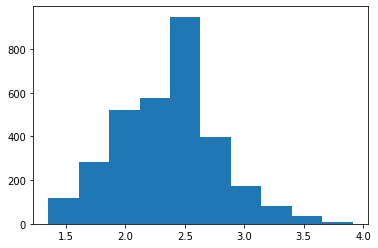

In [21]:
plt.hist(np.log(counties['eager_over_no']))

(array([  2.,  18.,   5., 231., 418., 552., 782., 746., 373.,  15.]),
 array([-0.6985453 , -0.51809357, -0.33764184, -0.1571901 ,  0.02326163,
         0.20371336,  0.38416509,  0.56461683,  0.74506856,  0.92552029,
         1.10597203]),
 <a list of 10 Patch objects>)

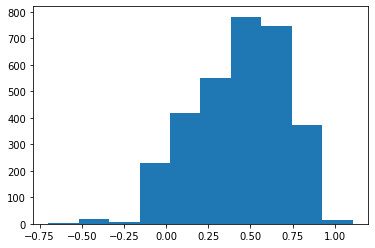

In [22]:
plt.hist(np.log(counties['somewhat_over_no']))

In [23]:
counties.drop('FIPS', axis=1)[feature_cols + response_cols].corr()

,hispanic_pct,black_pct,white_pct,SVI,eager_over_no,somewhat_over_no
hispanic_pct,1.000000,-0.115655,-0.601836,0.312908,0.228202,0.119327
black_pct,-0.115655,1.000000,-0.591361,0.475810,-0.043075,0.477057
white_pct,-0.601836,-0.591361,1.000000,-0.614748,-0.130603,-0.358495
SVI,0.312908,0.475810,-0.614748,1.000000,-0.228558,0.209659
eager_over_no,0.228202,-0.043075,-0.130603,-0.228558,1.000000,0.448324
somewhat_over_no,0.119327,0.477057,-0.358495,0.209659,0.448324,1.000000


In [24]:
def get_month_subgroup(polls ,month, subgroup):
    may = polls[polls['month'] == month]
    may_black = may[may['subgroup'] == subgroup]
    counts = np.array(may_black[data_cols]).sum(axis=0)
    return may_black, counts

In [25]:
data_cols = ['num_yes', 'num_hesitant', 'num_no']

In [34]:

may_black, black_tot_may = get_month_subgroup(polls, 5, 'black')
apr_black, black_tot_apr = get_month_subgroup(polls, 4, 'black')
mar_black, black_tot_mar = get_month_subgroup(polls, 3, 'black')
feb_black, black_tot_feb = get_month_subgroup(polls, 2, 'black')

black = np.row_stack([black_tot_apr, black_tot_may])
may_hisp, hisp_tot_may = get_month_subgroup(polls, 5, 'hispanic')
apr_hisp, hisp_tot_apr = get_month_subgroup(polls, 4, 'hispanic')
mar_hisp, hisp_tot_mar = get_month_subgroup(polls, 3, 'hispanic')
feb_hisp, hisp_tot_feb = get_month_subgroup(polls, 2, 'hispanic')


black_counts = np.vstack([black_tot_may, black_tot_apr, 
                          black_tot_mar, black_tot_feb])

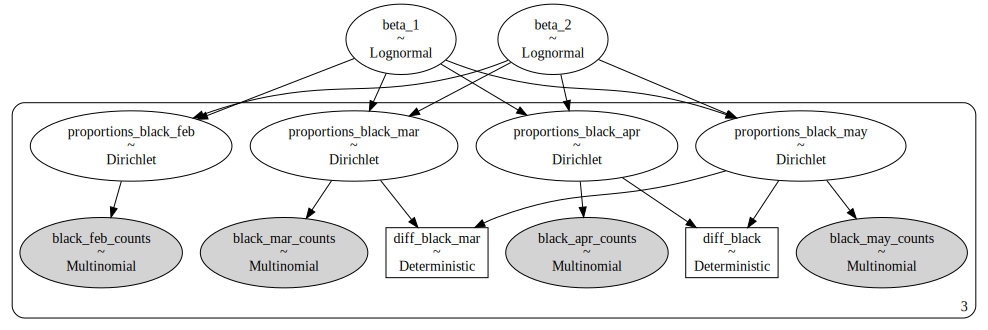

In [101]:
pm.model_to_graphviz(dirichlet_model)

In [102]:
with dirichlet_model:
    trace_dirichlet = pm.sample(draws=1000, chains=4, #step=pm.Metropolis(),
                                return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_black_may, proportions_black_apr, proportions_black_mar, proportions_black_feb, beta_2, beta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


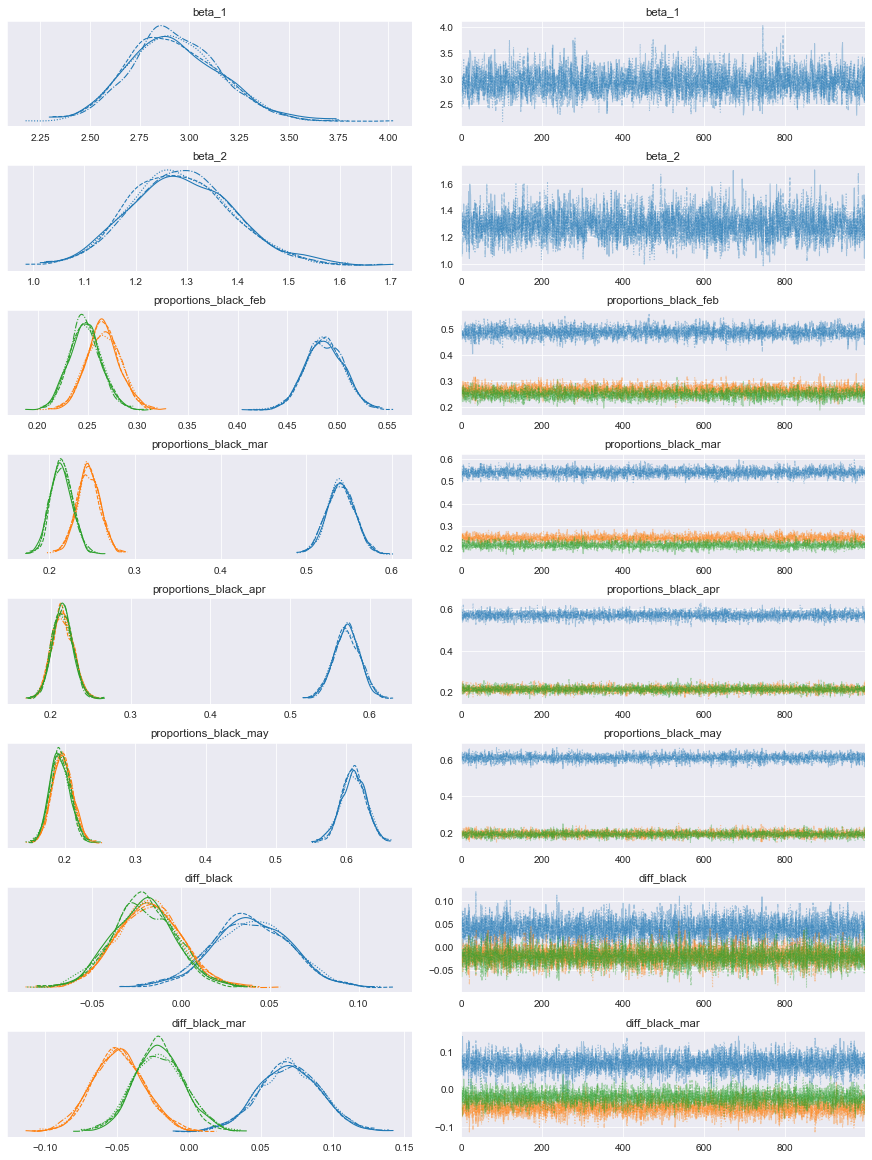

In [104]:
ax = az.plot_trace(data=trace_dirichlet)


In [76]:
summary = az.summary(trace_dirichlet, hdi_prob=0.9)

In [77]:
needed_rows = [i for i in summary.index if 'proportions_' in i]
to_plot = summary.filter(needed_rows, axis=0)[['mean', 'sd', 'hdi_5%', 'hdi_95%']]
to_plot['month'] = [2]*3 + [3]*3 + [4]*3 + [5]*3
to_plot['label'] = ['eager', 'hesitant', 'hard_no']*4

In [78]:
sns.set_style("darkgrid")

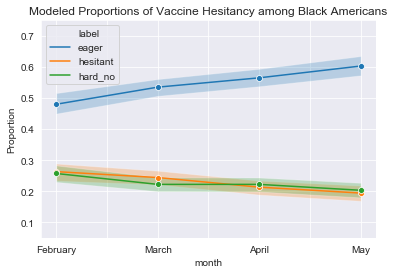

In [79]:
g = sns.lineplot(data=to_plot, x='month', y='mean', hue='label', ci='sd', marker='o', err_style='band')
g.set_xticklabels(['','February', '', 'March', '', 'April', '', 'May'])
g.set(ylim=(0.05,0.75), ylabel='Proportion', title='Modeled Proportions of Vaccine Hesitancy among Black Americans')
#g.fill_between(to_plot['month'], to_plot['hdi_5%'].values, to_plot['hdi_95%'].values, alpha=0.2) 
lvls = to_plot.label.unique()
for i in lvls:
    g.fill_between(x = to_plot[to_plot['label']==i]["month"],
                y1=to_plot[to_plot['label']==i]["hdi_5%"], 
                y2=to_plot[to_plot['label']==i]["hdi_95%"],label=i,
                  alpha=0.25)

In [99]:
with pm.Model() as dirichlet_model:
    
    k = 3
    
   # frac = pm.Dirichlet("frac", a=np.ones(k))
    
    
    beta_1 = pm.Lognormal('beta_1', mu=black_means[0], sigma=black_sds[0])
    beta_2 = pm.Lognormal('beta_2', mu=black_means[1], sigma=black_sds[1])
    
    
#     exp_b1 = pm.math.exp(beta_1)
#     exp_b2 = pm.math.exp(beta_2)
#    # pct_hesitant = pct_no * hesitant

#     a1 =  exp_b1 / (exp_b1 + exp_b1 + 1)
#     a2 =  exp_b1 / (exp_b1 + exp_b1 + 1)
#     a3 = 1 / (exp_b1 + exp_b1 + 1)
    
    a1 =  beta_1 / (beta_1 + beta_2 + 1)
    a2 =  beta_2 / (beta_1 + beta_2 + 1)
    a3 = 1 / (beta_1 + beta_2 + 1)
    
    arr = [a1,a2,a3]
    arr = [i*500 for i in arr]
    
    prop_black_feb = pm.Dirichlet(
        "proportions_black_feb",
       # a=np.array([1.0] * 3).astype("float32"),
        a=arr,#.astype('float32'),
        shape=(3,),
        testval=[0.1, 0.1, 0.1]
    )
    prop_black_mar = pm.Dirichlet(
        "proportions_black_mar",
       # a=np.array([1.0] * 3).astype("float32"),
        a=arr,#.astype('float32'),
        shape=(3,),
        testval=[0.1, 0.1, 0.1]
    )
    
    
    prop_black_apr = pm.Dirichlet(
        "proportions_black_apr",
       # a=np.array([1.0] * 3).astype("float32"),
        a=arr,#.astype('float32'),
        shape=(3,),
        testval=[0.1, 0.1, 0.1]
    )
    
    prop_black_may = pm.Dirichlet(
        "proportions_black_may",
       # a=np.array([1.0] * 3).astype("float32"),
        a=arr,#.astype('float32'),
        shape=(3,),
        testval=[0.1, 0.1, 0.1]
    )
    
    black_feb_counts = pm.Multinomial(
                    "black_feb_counts",
                    n=black_tot_feb.sum(),
                    p=prop_black_feb,
                    observed=black_tot_feb)

    black_mar_counts = pm.Multinomial(
                    "black_mar_counts",
                    n=black_tot_mar.sum(),
                    p=prop_black_mar,
                    observed=black_tot_mar)
    

    black_apr_counts = pm.Multinomial(
                    "black_apr_counts",
                    n=black_tot_apr.sum(),
                    p=prop_black_apr,
                    observed=black_tot_apr)
    
    black_may_counts = pm.Multinomial(
                    "black_may_counts",
                    n=black_tot_may.sum(),
                    p=prop_black_may,
                    observed=black_tot_may)

    
    pm.Deterministic("diff_black", prop_black_may-prop_black_apr)
    pm.Deterministic("diff_black_mar", prop_black_may-prop_black_mar)
  #  pm.Deterministic("diff_hisp", prop_hisp_may-prop_hisp_apr)
  ## ## pm.Deterministic("black_hisp_diff", prop_hisp_may-prop_black_may)


    
    

In [513]:
lvls = to_plot.label.unique()
for i in lvls:
    g.errorbar(x = to_plot[to_plot['label']==i]["month"],
                y=to_plot[to_plot['label']==i]["mean"], 
                yerr=to_plot[to_plot['label']==i]["sd"],label=i)

In [510]:
to_plot['hdi_5%'].values

array([0.451, 0.223, 0.24 , 0.511, 0.211, 0.207, 0.541, 0.181, 0.208,
       0.576, 0.158, 0.188])

In [503]:
fmri = sns.load_dataset("fmri")

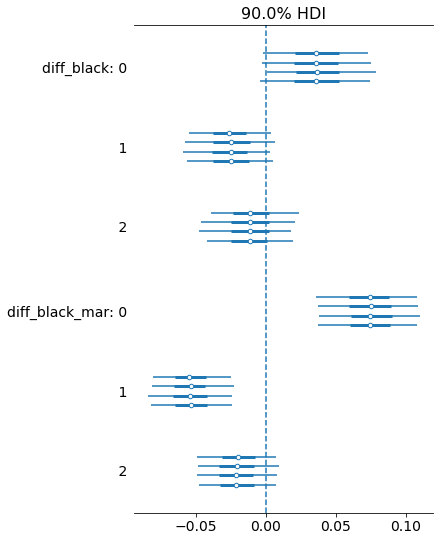

In [403]:
az.plot_forest(trace_dirichlet, var_names=["diff_black", "diff_black_mar"], hdi_prob=0.9)
plt.axvline(0, linestyle='--')
#plt.yticks(['Eager', 'Hesitant', 'Hard no'])

In [332]:
with dirichlet_model:
    ppc = pm.fast_sample_posterior_predictive(trace_dirichlet, keep_size=True)

In [335]:
az.forest_plot(ppc)

AttributeError: module 'arviz' has no attribute 'forest_plot'

In [107]:
with pm.Model() as hispanic_model:
        
    beta_1 = pm.Lognormal('beta_1', mu=hisp_means[0], sigma=hisp_sds[0])
    beta_2 = pm.Lognormal('beta_2', mu=hisp_means[1], sigma=hisp_sds[1])
        
    a1 =  beta_1 / (beta_1 + beta_2 + 1)
    a2 =  beta_2 / (beta_1 + beta_2 + 1)
    a3 = 1 / (beta_1 + beta_2 + 1)
    
    arr = [a1,a2,a3]
    arr = [i*500 for i in arr]
    
    prop_hisp_feb = pm.Dirichlet(
        "proportions_hisp_feb",
        a=arr,#_default,#.astype('float32'),
        shape=(3,)#,
        #testval=[0.1, 0.1, 0.1]
    )
    
    
    
    prop_hisp_mar = pm.Dirichlet(
        "proportions_hisp_mar",
        a=arr,#_default,#.astype('float32'),
        shape=(3,)#,
        #testval=[0.1, 0.1, 0.1]
    )
    
    
    prop_hisp_apr = pm.Dirichlet(
        "proportions_hisp_apr",
        a=arr,#_default,#.astype('float32'),
        shape=(3,)#,
     #   testval=[0.1, 0.1, 0.1]
    )
    
    prop_hisp_may = pm.Dirichlet(
        "proportions_hisp_may",
        a=arr,#_default,#.astype('float32'),
        shape=(3,)
        #,
        #testval=[0.1, 0.1, 0.1]
    )
 

    hisp_feb_counts = pm.Multinomial(
                    "hisp_feb_counts",
                    n=hisp_tot_feb.sum(),
                    p=prop_hisp_feb,
                    observed=hisp_tot_feb)
    

    hisp_mar_counts = pm.Multinomial(
                    "hisp_mar_counts",
                    n=hisp_tot_mar.sum(),
                    p=prop_hisp_mar,
                    observed=hisp_tot_mar)
    

    hisp_apr_counts = pm.Multinomial(
                    "hisp_apr_counts",
                    n=hisp_tot_apr.sum(),
                    p=prop_hisp_apr,
                    observed=hisp_tot_apr)
    
    hisp_may_counts = pm.Multinomial(
                    "hisp_may_counts",
                    n=hisp_tot_may.sum(),
                    p=prop_hisp_may,
                    observed=hisp_tot_may)
    

    # pm.Deterministic("diff_hisp", prop_hisp_may-prop_hisp_apr)
    pm.Deterministic("diff_hisp_mar", prop_hisp_may-prop_hisp_mar)
  #  pm.Deterministic("diff_hisp", prop_hisp_may-prop_hisp_apr)
  ## ## pm.Deterministic("hisp_hisp_diff", prop_hisp_may-prop_hisp_may)

    

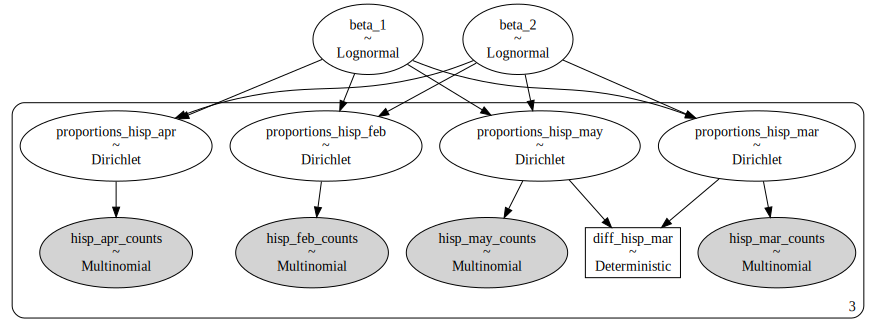

In [108]:
pm.model_to_graphviz(hispanic_model)

In [109]:
with hispanic_model:
    trace_hisp = pm.sample(draws=2000, chains=4,# step=pm.Metropolis(),
                                return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_hisp_may, proportions_hisp_apr, proportions_hisp_mar, proportions_hisp_feb, beta_2, beta_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a544af1d0>,
      dtype=object)

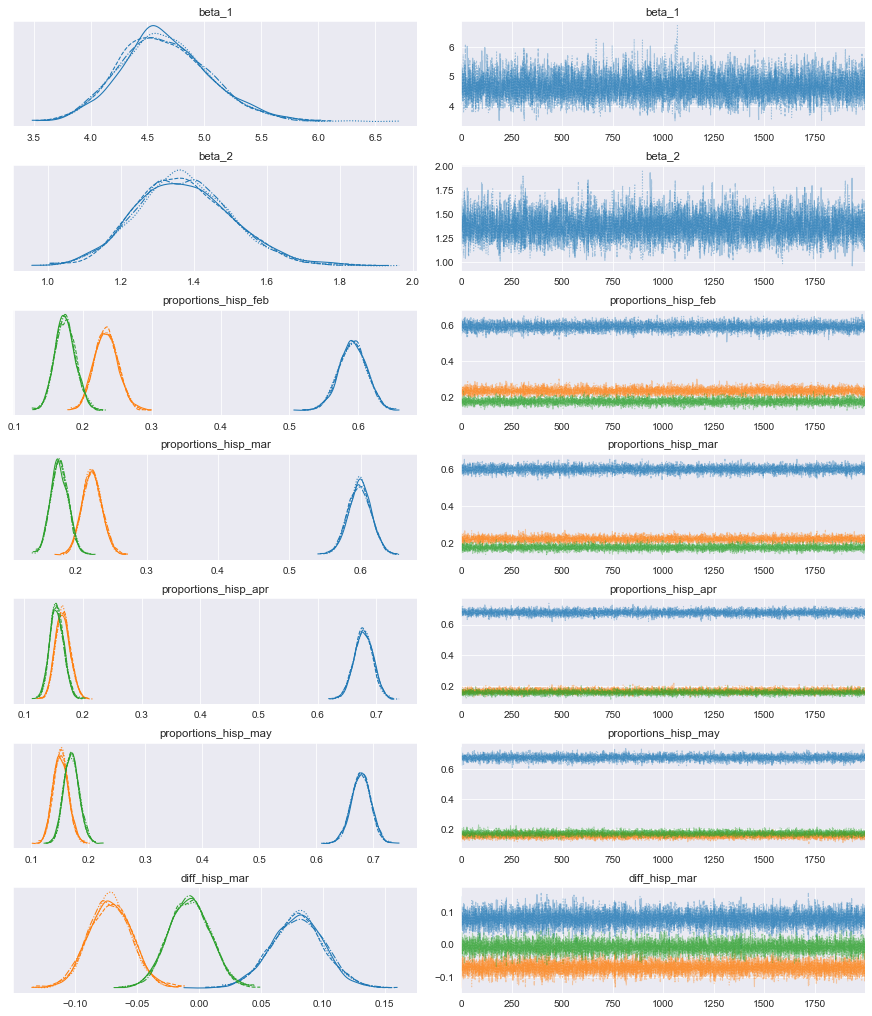

In [110]:
az.plot_trace(data=trace_hisp)

In [112]:
with hispanic_model:
    ppc = pm.fast_sample_posterior_predictive(trace_hisp, keep_size=True)
trace_hisp.extend(az.from_dict(posterior_predictive=ppc))


In [117]:
trace_hisp

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

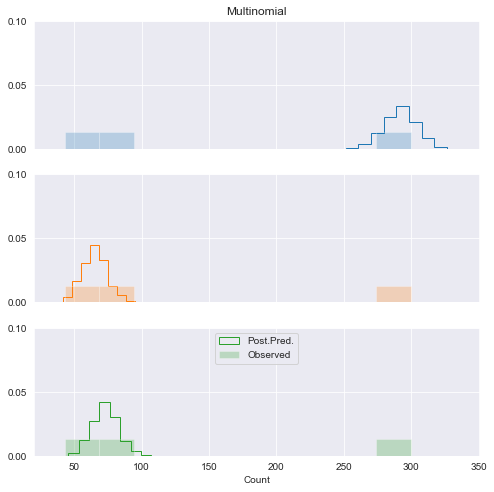

In [139]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 8))
for j, row in enumerate(axs):
    c = cmap(j)
    for _trace, ax in zip([trace_hisp], [row]):
        ax.hist(
            _trace.posterior_predictive.hisp_may_counts[:, :, j].values.flatten(),
            histtype="step",
            color=c,
            density=True,
            label="Post.Pred.",
        )
        ax.hist(
            (_trace.observed_data.hisp_may_counts.values.flatten()),
            color=c,
            density=True,
            alpha=0.25,
            label="Observed",
        )

axs[-1].legend(loc="upper center", fontsize=10)
axs[0].set_title("Multinomial")
axs[-1].set_xlabel("Count")
axs[-1].set_yticks([0, 0.05, 0.1])
axs[-1].set_ylim(0, 0.05)
ax.set_ylim(0, 0.1);                

In [140]:
_trace.observed_data.hisp_may_counts.values.flatten()

array([300,  43,  87], dtype=int32)

In [111]:
summary_hisp = az.summary(trace_hisp, hdi_prob=0.9)
summary_hisp

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_1,4.652,0.391,3.996,5.280,0.005,0.003,6817.0,5869.0,1.0
beta_2,1.374,0.131,1.160,1.586,0.002,0.001,6673.0,5769.0,1.0
proportions_hisp_feb[0],0.592,0.020,0.559,0.625,0.000,0.000,7532.0,6311.0,1.0
proportions_hisp_feb[1],0.234,0.017,0.207,0.263,0.000,0.000,7474.0,5868.0,1.0
proportions_hisp_feb[2],0.174,0.015,0.149,0.198,0.000,0.000,10316.0,6387.0,1.0
proportions_hisp_mar[0],0.598,0.016,0.573,0.626,0.000,0.000,8259.0,6275.0,1.0
proportions_hisp_mar[1],0.224,0.014,0.201,0.246,0.000,0.000,8198.0,5820.0,1.0
proportions_hisp_mar[2],0.178,0.012,0.158,0.198,0.000,0.000,9869.0,6311.0,1.0
proportions_hisp_apr[0],0.678,0.016,0.652,0.703,0.000,0.000,8224.0,5923.0,1.0
proportions_hisp_apr[1],0.166,0.012,0.145,0.186,0.000,0.000,7608.0,6197.0,1.0


In [577]:
needed_rows = [i for i in summary_hisp.index if 'proportions_' in i]
to_plot = summary_hisp.filter(needed_rows, axis=0)[['mean', 'sd', 'hdi_5%', 'hdi_95%']]
to_plot['month'] = [2]*3 + [3]*3 + [4]*3 + [5]*3
to_plot['label'] = ['eager', 'hesitant', 'hard_no']*4

g = sns.lineplot(data=to_plot, x='month', y='mean', hue='label', ci='sd', marker='o', err_style='band')
g.set_xticklabels(['','February', '', 'March', '', 'April', '', 'May'])
g.set(ylim=(0.05,0.75), ylabel='Proportion', title='Modeled Proportions of Vaccine Hesitancy among Hispanic Americans')
#g.fill_between(to_plot['month'], to_plot['s5%'].values, to_plot['hdi_95%'].values, alpha=0.2) 
lvls = to_plot.label.unique()
for i in lvls:
    g.fill_between(x = to_plot[to_plot['label']==i]["month"],
                y1=to_plot[to_plot['label']==i]["hdi_5%"], 
                y2=to_plot[to_plot['label']==i]["hdi_95%"],label=i,
                  alpha=0.25)

az.plot_forest(trace_hisp, var_names=["diff_hisp_mar"], hdi_prob=0.9)
plt.axvline(0, linestyle='--')
plt.title('Difference in Hispanic Hesitancy: March to May')

In [106]:
az.compare(
    {"dirichlet_model": trace_dirichlet, "hispanic_model": trace_hisp}, ic="loo"
)

NameError: name 'trace_hisp' is not defined

\begin{align}

\y_n &\sim Mult(\pi_{E}, \pi_{H}, \pi_{N}) \\
\beta_1 = \frac{\pi_{E}}{\pi_{N}} &\sim Lognormal(\mu_1, \sigma_1) \\
\beta_2 = \frac{\pi_{H}}{\pi_{N}} &\sim Lognormal(\mu_2, \sigma_2) \
\end{align}
where $\mu$ and $\sigma$ terms come from the means and SDs of these proportions 
for the top 100 counties for the specific subgroup.
